# Laboratorio #3 – Malware detection

El alcance del laboratorio se redujo a solamente desarrollar UN modelo, ya que la cuenta gratiuta se agotó al momento de generar los embeddings. 

Teniendo eso en cuenta se decidió implementar DOS modelos de ML, con el fin de tener un análisis comparativo al final del laboratorio. Se escogieron los modelos logistic regression (LR) y gradient boosting (GB).

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_curve, auc, classification_report

# Exploración de datos (EDA)

In [13]:
dataset = pd.read_csv('MalBehavD-V1-dataset.csv')

In [14]:
dataset.head(5)

,sha256,labels,0,1,2,3,4,5,6,7,...,165,166,167,168,169,170,171,172,173,174
0,5c18291c481a192ed5003084dab2d8a117fd3736359218...,0,LdrUnloadDll,CoUninitialize,NtQueryKey,NtDuplicateObject,GetShortPathNameW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4683faf3da550ffb594cf5513c4cbb34f64df85f27fd1c...,0,NtOpenMutant,GetForegroundWindow,NtQueryKey,DrawTextExW,NtSetInformationFile,RegQueryValueExA,LdrGetProcedureAddress,CoUninitialize,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9a0aea1c7290031d7c3429d0e921f107282cc6eab854ee...,0,GetForegroundWindow,DrawTextExW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtQueryValueKey,RegCloseKey,GetFileAttributesW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e0f3e4d5f50afd9c31e51dd9941c5a52d57c7c524f5d11...,0,NtQueryValueKey,LdrUnloadDll,GlobalMemoryStatus,WriteConsoleA,NtOpenKey,LdrGetProcedureAddress,NtTerminateProcess,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ec2b6d29992f13e74015ff0b129150b4afae15c593e4b7...,0,LdrUnloadDll,GetSystemTimeAsFileTime,NtOpenKey,WSAStartup,SetUnhandledExceptionFilter,NtTerminateProcess,NtClose,NtAllocateVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2570 entries, 0 to 2569
Columns: 177 entries, sha256 to 174
dtypes: int64(1), object(176)
memory usage: 3.5+ MB


In [22]:
dataset.isnull().sum().sort_values(ascending=False)

174       2569
163       2569
153       2569
155       2569
156       2569
          ... 
2            6
0            0
labels       0
1            0
sha256       0
Length: 177, dtype: int64

In [20]:
dataset.labels.value_counts()

labels
0    1285
1    1285
Name: count, dtype: int64

# Preprocesamiento

Como se puede observar el dataset en cuanto a labels está perfectamente balanceado. Por lo que no tendremos que preocuparnos por eso.
Ahora bien, dada la naturaleza del dataset, existe muchos valores NULL, lo cuál podría llegar a afectar la interpretación del modelo. Para evitar eso se decidió reemplazar todos los valores NULL por una cadena vacía "", simple. Con eso se asegurará que el vector generado con GoW y TF-DIF no se verá afectado.

In [24]:
dataset.fillna("", inplace=True)

# Ingeniería de características

In [38]:
apiCallsColumns = dataset.columns[2:]
dataset['callsSequence'] = dataset[apiCallsColumns].astype(str).agg(' '.join, axis=1)

# Bag of Words (BoW)
bowVectorizer = CountVectorizer()
X_bow = bowVectorizer.fit_transform(dataset['callsSequence'])

# TF-IDF
tfidfVectorizer = TfidfVectorizer()
X_tfidf = tfidfVectorizer.fit_transform(dataset['callsSequence'])
y = dataset['labels']

# Implementación

In [39]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bow, y, test_size=0.3, random_state=101, stratify=y)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=0.3, random_state=101, stratify=y)

In [83]:
def testModel(model, X_train, X_test, y_train, y_test, name):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    print(f"{name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Benigno', 'Malware'], yticklabels=['Benigno', 'Malware'])
    plt.title(f'Matriz de Confusión - {name}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()
    
    plt.figure()
    plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0,1], [0,1], linestyle="--", color="gray")
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title(f'Curva ROC - {name}')
    plt.legend(loc='lower right')
    plt.show()

### Modelos

In [84]:
logistic_regression = LogisticRegression()
gb_classifier = GradientBoostingClassifier()

### Para Bag of Words (BoW)

c:\Users\ealva\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ealva\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Logistic Regression - Accuracy: 0.9546, Precision: 0.9512, Recall: 0.9585
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       385
           1       0.95      0.96      0.95       386

    accuracy                           0.95       771
   macro avg       0.95      0.95      0.95       771
weighted avg       0.95      0.95      0.95       771



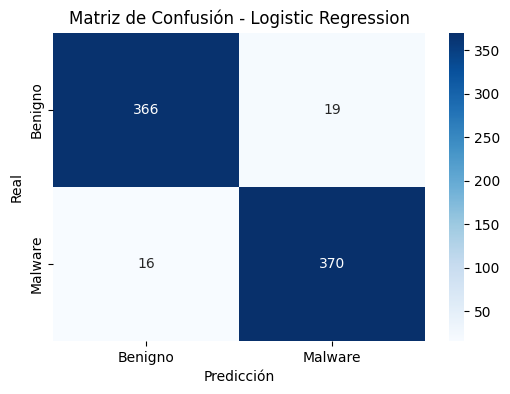

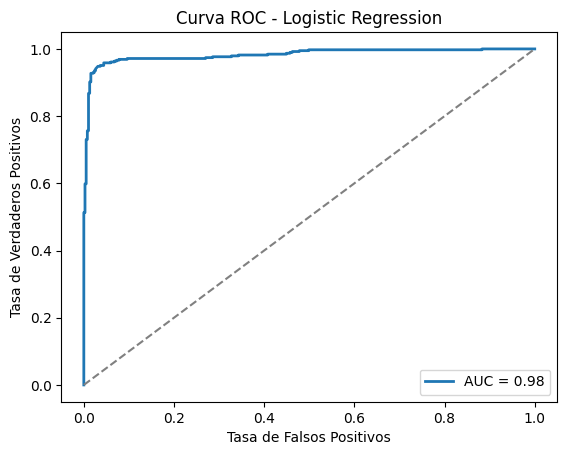

In [86]:
testModel(logistic_regression, X_train_bow, X_test_bow, y_train_bow, y_test_bow, "Logistic Regression")

Gradient Boosting - Accuracy: 0.9624, Precision: 0.9786, Recall: 0.9456
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       385
           1       0.98      0.95      0.96       386

    accuracy                           0.96       771
   macro avg       0.96      0.96      0.96       771
weighted avg       0.96      0.96      0.96       771



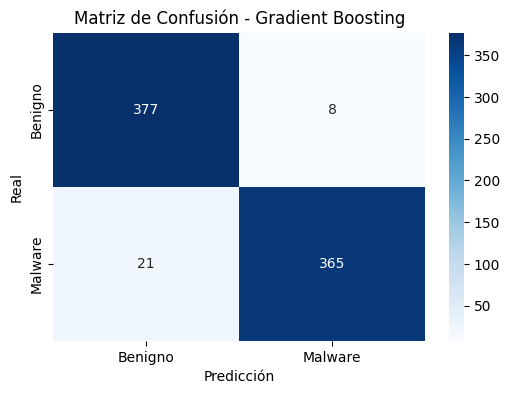

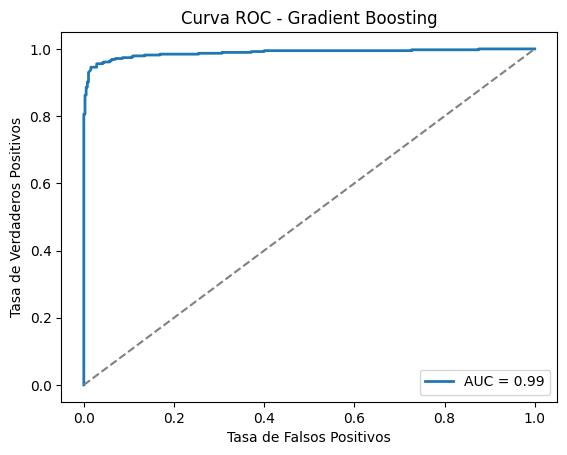

In [87]:
testModel(gb_classifier, X_train_bow, X_test_bow, y_train_bow, y_test_bow, "Gradient Boosting")

#### Explicación de méticas

Ambos presentaron resultados muy buenos y parecidos.

**Acurracy:** LR entregó un 95.46%, mientras que GB un 96.24% de accuracy, indicando que ambos lograron una exactitud muy alta a la hora de clasificar un conjunto de llamadas a la API.

**Precision:** LR 95.12% y GB 97.86%, aunque ambos son altos, GB tiene una precisión significativamente mayor. Y esto se puede comprobar también con la matriz de confusión, en la que GB muestra 377 TP (True Positive) y LR solamente cuenta con 366 TP. Aunque no GB no tenga menos FP (Fasle Positive) que LR, lo indicado anteriormente prueba porqué GB tuvo mayor precisión que LR.

**Recall:** LR 95.85% y GB 94.56%. Indicando que LR identificó más malwares correctamente. Se puede confirmar en la matriz de confusión, donde GB tiene 365 TP, mientras que LR tiene 370 TP.

**AUC:** LR 0.98 y GB 0.99. Ambos fueron muy altos, haciendo que ambos fueran altamente capaces de clasificar correctamente.

Generalmente, Gradient Boosting demostró ser mejor que Logistic Regression utilizando Bag of Words.

### Para TF-IDF

Logistic Regression - Accuracy: 0.9507, Precision: 0.9677, Recall: 0.9326
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       385
           1       0.97      0.93      0.95       386

    accuracy                           0.95       771
   macro avg       0.95      0.95      0.95       771
weighted avg       0.95      0.95      0.95       771



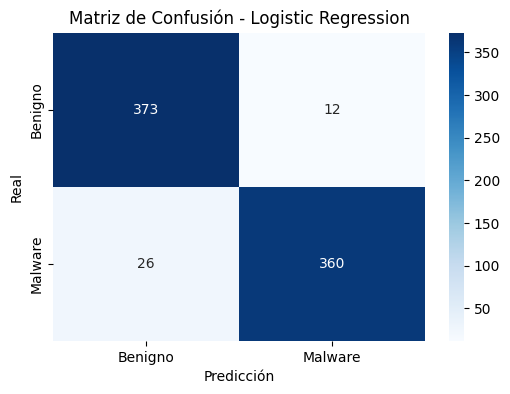

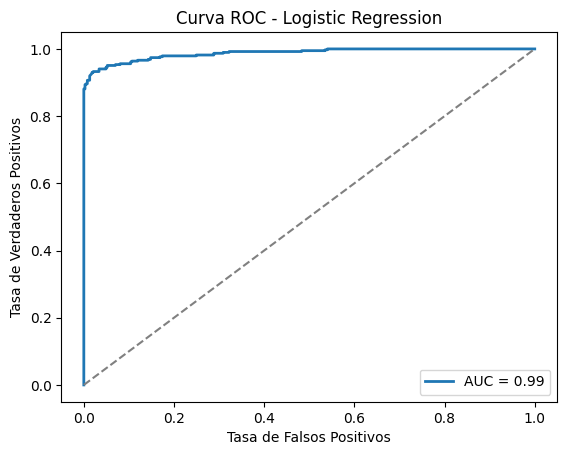

In [88]:
testModel(logistic_regression, X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf, "Logistic Regression")

Gradient Boosting - Accuracy: 0.9559, Precision: 0.9681, Recall: 0.9430
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       385
           1       0.97      0.94      0.96       386

    accuracy                           0.96       771
   macro avg       0.96      0.96      0.96       771
weighted avg       0.96      0.96      0.96       771



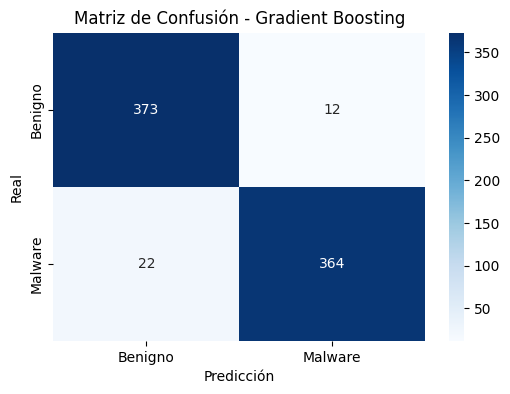

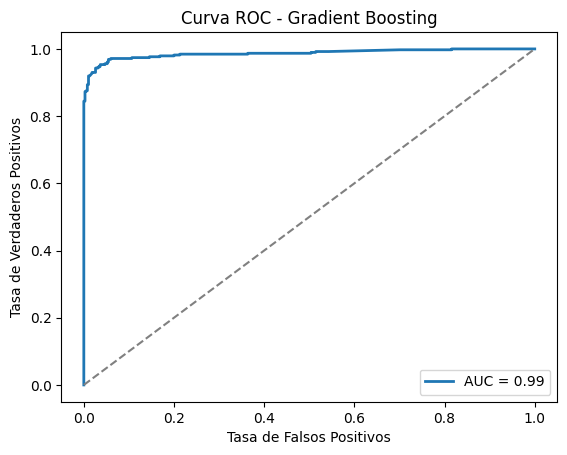

In [89]:
testModel(gb_classifier, X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf, "Gradient Boosting")

#### Explicación de métricas

Ambos presentaron resultados muy buenos y parecidos.

**Acurracy:** LR 95.07% y GB un 95.59%. Básicamente iguales.

**Precision:** LR 96.77% y GB 96.81%. Realmente sin diferencia signficativa, también se puede confirmar en la matriz de confusión. Donde solamente se diferencian por 4 en los FP.

**Recall:** LR 93.26% y GB 94.30%. Ya con una diferencia significativa, GB fue mejor que LR al detectar más TP, lo cual se puede confirmar en la matriz de confusión.

**AUC:** LR 0.99 y GB 0.99. Idénticos.

Muy pero muy ligeramente, Gradient Boosting demostró ser mejor que Logistic Regression utilizando TF-IDF.